In [1]:
# Importing necessary packages
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import LeaveOneOut

In [2]:
dataset = load_breast_cancer() # loading dataset
print(dataset.keys()) # lists the contents of the dataset
print(dataset.data.shape) # shape of the X matrix

data=dataset.data # Get data matrix
target=dataset.target # Get target data
feature_names=dataset.feature_names # Save feature names

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename', 'data_module'])
(569, 30)


### **1. PCA**

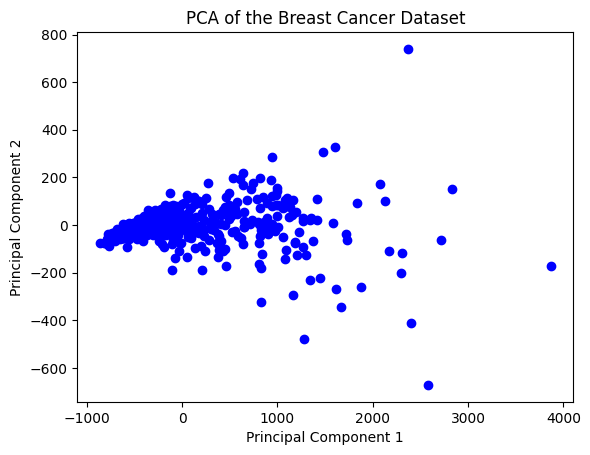

In [4]:
# Initializing PCA with 2 components
pca = PCA(n_components=2).fit_transform(data)

plt.scatter(pca[:, 0], pca[:, 1], c='b') # Creating scatterplot of transformed data

# Add axis and plot titles
plt.title('PCA of the Breast Cancer Dataset')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show() # Display plot

### **2. Correlation**

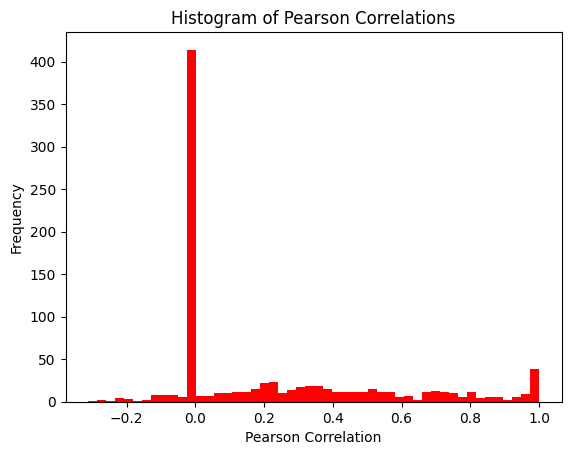

In [5]:
corr = np.corrcoef(data, rowvar=False) # Calculating pearson correlation

# Plotting histogram of pearson correlations with 50 bins
plt.hist(np.tril(corr, k=1).flatten(), bins=50, color='red')

# Add axis and plot titles
plt.xlabel('Pearson Correlation')
plt.ylabel('Frequency')
plt.title('Histogram of Pearson Correlations')
plt.show() # Display plot

### **3. Mean Concavity vs. Worst Area**

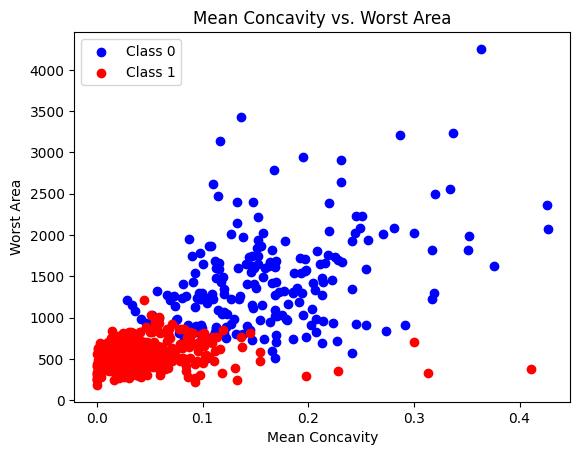

In [6]:
# Getting both columns of mean_concavity & worst_area
mean_concavity = data[:, 6] # mean_concavity is the 6th column
worst_area = data[:, 23] # worst_area is the 23rd column

# Scatterplot for class 0
plt.scatter(mean_concavity[target == 0], worst_area[target == 0], color='blue',
            label='Class 0')

# Scatterplot for class 1
plt.scatter(mean_concavity[target == 1], worst_area[target == 1], color='red',
            label='Class 1')

# Add labels and title
plt.title('Mean Concavity vs. Worst Area')
plt.xlabel('Mean Concavity')
plt.ylabel('Worst Area')
plt.legend() # Add legend
plt.show() # Display plot

### **4. Violinplot of Mean, Median & Variance**

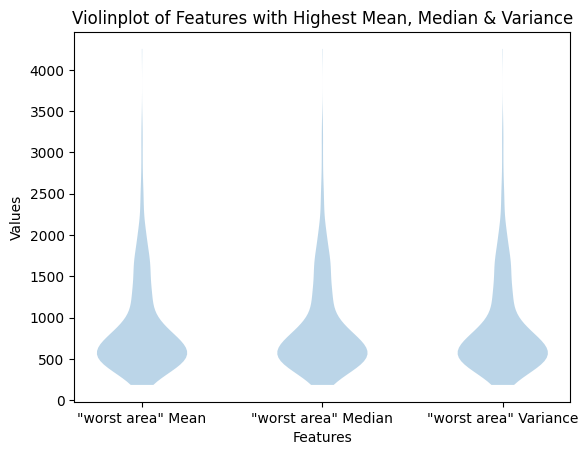

In [7]:
# Calculate mean, median & variance of each column
mean, median, variance = np.mean(data, axis=0), np.median(data, axis=0), np.var(data, axis=0)

# Get indices of the features with the highest mean, median & var
mean_index, median_index, var_index = np.argmax(mean), np.argmax(median), np.argmax(variance)

# Extract the corresponding features
highest_mean_feature = data[:,mean_index]
highest_median_feature = data[:,median_index]
highest_var_feature = data[:,var_index]

# Create violinplot
plt.violinplot([highest_mean_feature, highest_median_feature, highest_var_feature], showextrema=False)

# Add labels for each feature in plot
mean_label='"'+ feature_names[mean_index] +'" Mean'
median_label='"'+ feature_names[median_index] +'" Median'
var_label='"'+ feature_names[var_index] +'" Variance'
plt.xticks([1,2,3], [mean_label, median_label, var_label]) # Add xticks

# Add labels and title
plt.title('Violinplot of Features with Highest Mean, Median & Variance')
plt.ylabel('Values')
plt.xlabel('Features')
plt.show() # Display plot

### **5. Logistic Regression**

In [8]:
# Divide data into train & test sets
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2,
                                                    shuffle=False, random_state=42)

# Train logistic regression classififer on training split and score on test split
log_model = LogisticRegression(max_iter=5000)
log_model.fit(X_train, y_train)
accuracy = log_model.score(X_test, y_test) # Get classification accuracy

iterations = log_model.n_iter_[0] # Get number of iterations

print(f"Out-of-sample classification accuracy: {accuracy:.4f}")
print(f"Number of iterations for convergence: {iterations}")

Out-of-sample classification accuracy: 0.9298
Number of iterations for convergence: 2286


### **6. Pipeline Model**

In [9]:
# Make pipeline model using logistic regression model
pipeline_model = make_pipeline(StandardScaler(), log_model)

# Train model on training split and score on test split
pipeline_model.fit(X_train, y_train)
pipeline_accuracy = pipeline_model.score(X_test, y_test)

# Get number of iterations
pipeline_iterations = pipeline_model.named_steps['logisticregression'].n_iter_[0]

print(f"Out-of-sample classification accuracy: {pipeline_accuracy:.4f}")
print(f"Number of iterations for convergence: {pipeline_iterations}")

Out-of-sample classification accuracy: 0.9825
Number of iterations for convergence: 30


### **7. K-Fold**

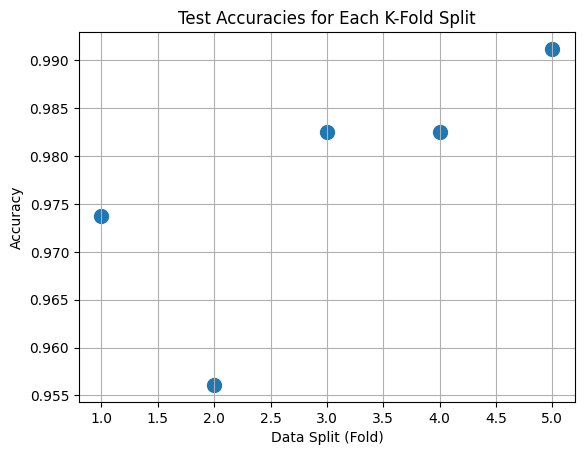

Test accuracies for each split: [0.9737, 0.9561, 0.9825, 0.9825, 0.9912]


In [33]:
k_fold = KFold(n_splits=5, shuffle=False) # Create KFold object with 5 splits

accuracies = [] # List to store the accuracies of each fold

# Perform KFold cross-validation
for train_index, test_index in k_fold.split(data):
    X_train, X_test = data[train_index], data[test_index] # Split data
    y_train, y_test = target[train_index], target[test_index] # Split target

    pipeline_model.fit(X_train, y_train) # Train pipeline model on the training split

    # Predict & calculate accuracy on the test split
    y_pred = pipeline_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    accuracies.append(round(accuracy,4)) # Store accuracy for current fold

plt.scatter(range(1, 6), accuracies, s=100) # Scatterplot of test accuracies for each split

# Add labels, title & grid
plt.title('Test Accuracies for Each K-Fold Split')
plt.xlabel('Data Split (Fold)')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show() # Display plot

print(f"Test accuracies for each split: {accuracies}") # Print accuracies

### **8. LeaveOneOut**

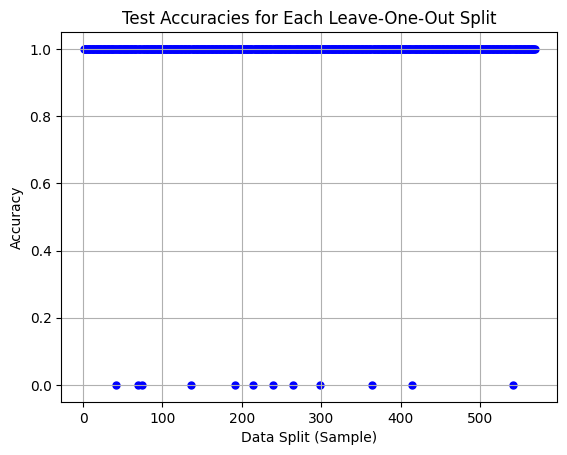

Average accuracy: 0.9789


In [35]:
leave_one_out = LeaveOneOut() # Create LeaveOneOut object

accuracies = [] # List to store accuracies of each split

# Perform LeaveOneOut cross-validation
for train_index, test_index in leave_one_out.split(data):
    X_train, X_test = data[train_index], data[test_index] # Split data
    y_train, y_test = target[train_index], target[test_index] # Split target

    pipeline_model.fit(X_train, y_train) # Fit pipeline_model on train split

    # Predict & calculate accuracy on test split
    y_pred = pipeline_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    accuracies.append(round(accuracy,4)) # Store accuracy for current split

# Create scatterplot of test accuracies for each split
plt.scatter(range(1, len(accuracies) + 1), accuracies, color='blue', s=25)

# Add labels, title & grid
plt.title('Test Accuracies for Each Leave-One-Out Split')
plt.xlabel('Data Split (Sample)')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show() # Display plot

# Print average accuracy
average_accuracy = np.mean(accuracies)
print(f"Average accuracy: {average_accuracy:.4f}")